<a href="https://colab.research.google.com/github/akash-agni/DeepLearning/blob/Akash/CIFAR_10_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from sklearn.metrics import accuracy_score

In [3]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2021-02-07 15:01:45--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  99.9MB/s    in 1.6s    

2021-02-07 15:01:47 (99.9 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [4]:
!mkdir ./cifar_10/
!tar -xf cifar-10-python.tar.gz -C ./cifar_10/
!rm -rf cifar-10-python.tar.gz

In [5]:
!ls -l ./cifar_10/cifar-10-batches-py/

total 181876
-rw-r--r-- 1 2156 1103      158 Mar 31  2009 batches.meta
-rw-r--r-- 1 2156 1103 31035704 Mar 31  2009 data_batch_1
-rw-r--r-- 1 2156 1103 31035320 Mar 31  2009 data_batch_2
-rw-r--r-- 1 2156 1103 31035999 Mar 31  2009 data_batch_3
-rw-r--r-- 1 2156 1103 31035696 Mar 31  2009 data_batch_4
-rw-r--r-- 1 2156 1103 31035623 Mar 31  2009 data_batch_5
-rw-r--r-- 1 2156 1103       88 Jun  4  2009 readme.html
-rw-r--r-- 1 2156 1103 31035526 Mar 31  2009 test_batch


In [6]:
workdir = os.curdir
datadir = os.path.join(workdir,'cifar_10','cifar-10-batches-py')
train_files = [os.path.join(datadir,f'data_batch_{i}') for i in range(1,6)]
test_file = 'test_batch'

In [7]:
# unpickle the data file containing the image
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [8]:
data_dict = unpickle(train_files[0])
data_dict.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [9]:
# read all files into a dataset
data = np.empty(data_dict[b'data'].shape)
labels = list()
for fl in train_files:
  print(f"Loading File {fl}")
  df = unpickle(fl)
  print(df[b'batch_label'])
  print(f"Geting Data")
  if df[b'batch_label'] == b'training batch 1 of 5':
    data = df[b'data']
  else:
    data = np.concatenate([data,df[b'data']])
  print("Geting labels")
  labels = labels + df[b'labels']
  print(f"Shape of Data is {data.shape}")
  print("="*50)

Loading File ./cifar_10/cifar-10-batches-py/data_batch_1
b'training batch 1 of 5'
Geting Data
Geting labels
Shape of Data is (10000, 3072)
Loading File ./cifar_10/cifar-10-batches-py/data_batch_2
b'training batch 2 of 5'
Geting Data
Geting labels
Shape of Data is (20000, 3072)
Loading File ./cifar_10/cifar-10-batches-py/data_batch_3
b'training batch 3 of 5'
Geting Data
Geting labels
Shape of Data is (30000, 3072)
Loading File ./cifar_10/cifar-10-batches-py/data_batch_4
b'training batch 4 of 5'
Geting Data
Geting labels
Shape of Data is (40000, 3072)
Loading File ./cifar_10/cifar-10-batches-py/data_batch_5
b'training batch 5 of 5'
Geting Data
Geting labels
Shape of Data is (50000, 3072)


In [10]:
# Reading Metadata
label_meta = unpickle(os.path.join(datadir,'batches.meta'))[b'label_names']
label_meta_mapping = {i:label_meta[i].decode('utf-8') for i in range(len(label_meta))}
label_meta_mapping

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [11]:
labels = np.array(labels)
for i in range(0,10):
  lb_count = np.sum((labels == i)*1)
  print(f"{label_meta_mapping[i]}: {lb_count}")

airplane: 5000
automobile: 5000
bird: 5000
cat: 5000
deer: 5000
dog: 5000
frog: 5000
horse: 5000
ship: 5000
truck: 5000


In [12]:
data_rgb = np.reshape(data, (data.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1)

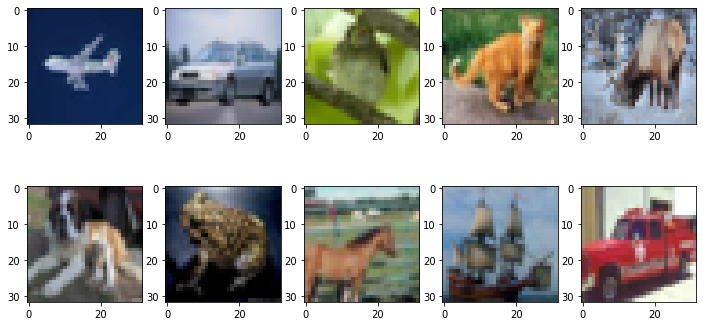

In [13]:
rnd_idx = np.random.randint(1,5000)
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12,6))
for i in range(10):
  samp = data_rgb[labels == i][rnd_idx,:,:,:]
  ax[int(i/5)][i%5].imshow(samp)

In [17]:
train_X, test_X, train_y, test_y = train_test_split(data_rgb/255, np.array(labels), test_size=0.2)
test_X, val_X, test_y, val_y = train_test_split(test_X, test_y, test_size=0.7)
print(f"Training Data Size : {train_X.shape[0]}")
print(f"Validation Data Size : {val_X.shape[0]}")
print(f"Testing Data Size : {test_X.shape[0]}")

Training Data Size : 40000
Validation Data Size : 7000
Testing Data Size : 3000


In [170]:
inputs = tf.keras.Input(shape=train_X.shape[1:])
columns = list()
for _ in range(3):
  x = tf.keras.layers.Conv2D(64, 8, activation='relu', strides=(1,1), padding='same', data_format='channels_last', kernel_regularizer='l2')(inputs)
  x = tf.keras.layers.Conv2D(64, 8, activation='relu', strides=(1,1), padding='same', data_format='channels_last')(x)
  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), data_format='channels_last')(x)
  
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.3)(x)
  x = tf.keras.layers.Conv2D(128, 4, activation='relu', strides=(1,1), padding='same', data_format='channels_last')(x)
  x = tf.keras.layers.Conv2D(128, 4, activation='relu', strides=(1,1), padding='same', data_format='channels_last')(x)
  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), data_format='channels_last')(x)

  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.3)(x)
  x = tf.keras.layers.Conv2D(256, 3, activation='relu', strides=(1,1), padding='same', data_format='channels_last')(x)
  x = tf.keras.layers.Conv2D(256, 3, activation='relu', strides=(1,1), padding='same', data_format='channels_last')(x)
  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), data_format='channels_last')(x)

  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.3)(x)
  x = tf.keras.layers.Conv2D(512, 2, activation='relu', strides=(1,1), padding='same', data_format='channels_last')(x)
  x = tf.keras.layers.Conv2D(512, 2, activation='relu', strides=(1,1), padding='same', data_format='channels_last')(x)
  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), data_format='channels_last')(x)

  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)

  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)

  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dense(64, activation='relu')(x)

  columns.append(x)

x = tf.keras.layers.concatenate(columns)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)

outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [171]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [172]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#model.build(input_shape=train_X.shape[1:])
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 32, 32, 64)   12352       input_23[0][0]                   
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 32, 32, 64)   12352       input_23[0][0]                   
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 32, 32, 64)   12352       input_23[0][0]                   
___________________________________________________________________________________________

In [173]:
erly_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.0001, patience=10, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True,
)

In [174]:
history = model.fit(x=train_X, y=train_y, batch_size=32, epochs=100, validation_data=(val_X, val_y), workers=-1, callbacks=erly_stop)

Epoch 1/100
1250/1250 [==============================] - 83s 64ms/step - loss: 2.1601 - accuracy: 0.2684 - val_loss: 1.6915 - val_accuracy: 0.3917
Epoch 2/100
1250/1250 [==============================] - 80s 64ms/step - loss: 1.5498 - accuracy: 0.4459 - val_loss: 1.7754 - val_accuracy: 0.4071
Epoch 3/100
1250/1250 [==============================] - 80s 64ms/step - loss: 1.3571 - accuracy: 0.5179 - val_loss: 1.2197 - val_accuracy: 0.5737
Epoch 4/100
1250/1250 [==============================] - 80s 64ms/step - loss: 1.1995 - accuracy: 0.5804 - val_loss: 1.2456 - val_accuracy: 0.5714
Epoch 5/100
1250/1250 [==============================] - 80s 64ms/step - loss: 1.0730 - accuracy: 0.6241 - val_loss: 1.3731 - val_accuracy: 0.5619
Epoch 6/100
1250/1250 [==============================] - 80s 64ms/step - loss: 0.9837 - accuracy: 0.6608 - val_loss: 1.0440 - val_accuracy: 0.6407
Epoch 7/100
1250/1250 [==============================] - 80s 64ms/step - loss: 0.9040 - accuracy: 0.6882 - val_loss: 1

In [175]:
def top_5_error_rate(predict_proba, y_true):
  result = 0
  for i in range(len(y_true)):
    row = predict_proba[i,:]
    top_5 = sorted(range(len(row)), key = lambda x: row[x], reverse=True)[:5]
    if y_true[i] in top_5:
      result = result + 1
  
  return result/len(y_true)

In [176]:
proba_train_X = model.predict(test_X)
print(f'Accuracy Score : {model.evaluate(test_X, test_y)}')
print(top_5_error_rate(proba_train_X, test_y))

94/94 [==============================] - 2s 17ms/step - loss: 0.7576 - accuracy: 0.7513
Accuracy Score : [0.7576127052307129, 0.7513333559036255]
0.9846666666666667


In [177]:
test_batch = unpickle(os.path.join(datadir,'test_batch'))
test_data = test_batch[b'data']
test_labels = test_batch[b'labels']

In [149]:
test_data = np.reshape(test_data, (test_data.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1)

'deer'

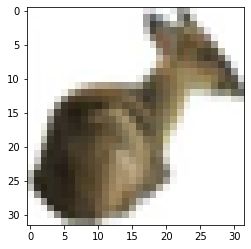

In [150]:
idx = np.random.randint(200)
plt.imshow(test_data[idx])
label_meta_mapping[test_labels[idx]]

In [151]:
proba_train_X = model.predict(test_data/255)
print(f'Accuracy Score : {model.evaluate(test_data/255, np.array(test_labels))}')
print(top_5_error_rate(proba_train_X, test_labels))

313/313 [==============================] - 2s 7ms/step - loss: 0.7458 - accuracy: 0.7688
Accuracy Score : [0.745808482170105, 0.7688000202178955]
0.9833


Acutal Label: cat
Predicted Label: dog
['dog', 'horse', 'cat', 'airplane', 'automobile']


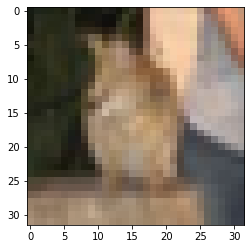

In [168]:
idx = np.random.randint(200)
prediction = model.predict(np.array([test_data[idx]]))
prediction = label_meta_mapping[np.argmax(prediction)]
actual = label_meta_mapping[test_labels[idx]]
print(f"Acutal Label: {actual}\nPredicted Label: {prediction}")
row = model.predict(np.array([test_data[idx]]))[0]
top_5 = sorted(range(len(row)), key = lambda x: row[x], reverse=True)[:5]
top_5 = [label_meta_mapping[i] for i in top_5]
print(top_5)
fig = plt.imshow(test_data[idx])

['dog', 'cat', 'horse', 'airplane', 'automobile']